<a href="https://colab.research.google.com/github/ViktorJOlah/Neuro_ANN/blob/main/top%20layer%20encoders/Gcamp_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#this is for testing purposes, for getting the most out of GPU

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 


from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
#drive.flush_and_unmount()
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 12.7 GB  | Proc size: 95.3 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0

In [ ]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LocallyConnected1D

from keras.models import Sequential
from tensorflow.keras import regularizers



import keras

import tensorflow as tf

import random

import matplotlib.pyplot as plt
import gc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  import sys


In [ ]:
params = {
    "batch_size": 64,
    "epochs": 1,
    "lr": 0.0010000,
    "time_steps": 3000,
    "rec_length": 20000
}


TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()
steps_per_epoch = 2000

In [ ]:
data = pd.read_csv('/content/drive/My Drive/DNN/ANN_revision/Gcamp/higher_activity.txt', sep=" ", header=None, on_bad_lines="skip")

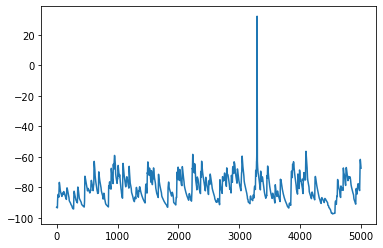

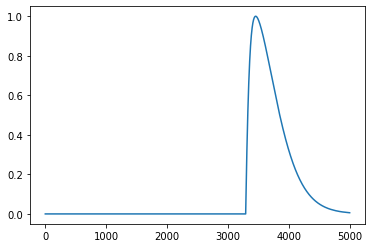

In [ ]:
plt.plot(data[0][:5000])
plt.show()
plt.plot(data[5][:5000])

In [ ]:
x_vm = np.asarray(data[0])
x_gcamp = np.asarray(data[5])

In [ ]:
np.mean(x_vm)

-82.63130215243119

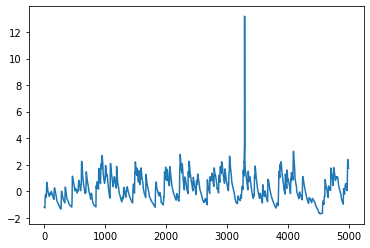

In [ ]:
x_vm = (x_vm-np.mean(x_vm))/np.std(x_vm)
plt.plot(x_vm[:5000])

In [ ]:
del data

In [ ]:
x_vm.shape[0]

2020101

In [ ]:
x_vm_dim0 = x_vm.shape[0]-TIME_STEPS-10

rand_x_train = random.sample(range(x_vm_dim0), int(x_vm_dim0*0.9))
rand_x_test = np.setdiff1d(range(x_vm_dim0), rand_x_train)

In [ ]:

def gen1(df_vm, df_gcamp, rand_vec, TIME_STEPS, BATCH_SIZE):
    dim_0 = df_vm.shape[0] - TIME_STEPS
    x = np.zeros((BATCH_SIZE, 1, TIME_STEPS))
    y = np.zeros((BATCH_SIZE, TIME_STEPS))
    try:
        place = int(len(rand_vec)*random.random())
        randvec = rand_vec[place:place+BATCH_SIZE]
        for i in range(BATCH_SIZE):
            x[i] = np.reshape(df_vm[randvec[i]:TIME_STEPS+randvec[i]], [1,3000])
            y[i] = df_gcamp[randvec[i]:TIME_STEPS+randvec[i]]
    except:
        for i in range(BATCH_SIZE):
            x[i] = np.reshape(df_vm[:TIME_STEPS], [1,3000])
            y[i] = np.reshape(df_gcamp[:TIME_STEPS], [1,3000])

    yield x, y





x_train_counter = tf.data.Dataset.from_generator(gen1, args=[x_vm, x_gcamp, rand_x_train, TIME_STEPS, BATCH_SIZE], output_types=(tf.float16, tf.float16), output_shapes = ((64,1,3000), (64,3000)) ).repeat().prefetch(tf.data.experimental.AUTOTUNE)
x_test_counter = tf.data.Dataset.from_generator(gen1, args=[x_vm, x_gcamp, rand_x_test, TIME_STEPS, BATCH_SIZE], output_types=(tf.float16, tf.float16), output_shapes = ((64,1,3000), (64,3000)) ).repeat(count=500).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
x1, y1 = next(gen1(x_vm, x_gcamp, rand_x_train, TIME_STEPS, BATCH_SIZE))

In [ ]:
x1.shape

(64, 1, 3000)

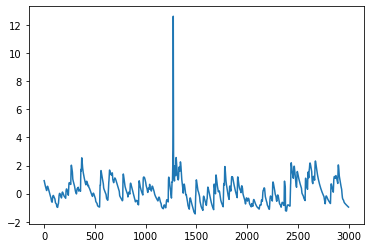

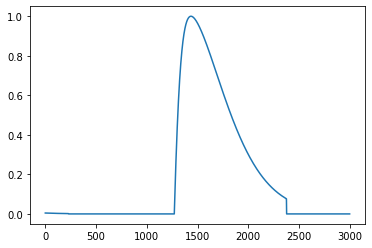

In [ ]:
plt.plot(x1[0][0])
plt.show() 
plt.plot(y1[0])

In [ ]:
def create_model():

    encoder_input = keras.Input(shape=(1,3000))
    x = tf.keras.layers.LSTM(250, return_sequences=True)(encoder_input)
    x = tf.keras.layers.LSTM(10)(x)
    x = tf.keras.layers.RepeatVector(10)(x)
    x = tf.keras.layers.LSTM(250, return_sequences=True)(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3000, activation="selu"))(x)
    encoder_output = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=False))(x)

    encoder = keras.Model(encoder_input, encoder_output, name="encoder")

    encoder.compile(loss='mse', optimizer='Nadam')
    return encoder


model = create_model()
model.summary()

model = tf.keras.models.load_model('/content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.378-0.003432-gcamp_deconvolution')

filepath = "weights.{epoch:02d}-{loss:.6f}-gcamp_deconvolution"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                    patience=50, min_delta=0.0001)
    
mcp = ModelCheckpoint(f"/content/drive/My Drive/DNN/ANN_revision/Gcamp/{filepath}", monitor='val_loss', verbose=1,
                        save_best_only=True, save_weights_only=False, mode='min', period=1)

# Not used here. But leaving it here as a reminder for future
r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, 
                                verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    
history = model.fit(x_train_counter, epochs=50000, steps_per_epoch = 5000, verbose=1, batch_size=64,
                    shuffle=False, validation_data=x_test_counter, validation_steps=400, use_multiprocessing=False, callbacks=[es, mcp, r_lr_plat])


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 3000)]         0         
                                                                 
 lstm_39 (LSTM)              (None, 1, 250)            3251000   
                                                                 
 lstm_40 (LSTM)              (None, 10)                10440     
                                                                 
 repeat_vector_13 (RepeatVec  (None, 10, 10)           0         
 tor)                                                            
                                                                 
 lstm_41 (LSTM)              (None, 10, 250)           261000    
                                                                 
 time_distributed_13 (TimeDi  (None, 10, 3000)         753000    
 stributed)                                                

Epoch 1/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0219
Epoch 1: val_loss improved from inf to 0.02415, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.01-0.021888-gcamp_deconvolution


5000/5000 [==============================] - 96s 18ms/step - loss: 0.0219 - val_loss: 0.0242 - lr: 0.0010
Epoch 2/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0220
Epoch 2: val_loss did not improve from 0.02415
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0220 - val_loss: 0.0245 - lr: 0.0010
Epoch 3/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0217
Epoch 3: val_loss did not improve from 0.02415
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0217 - val_loss: 0.0258 - lr: 0.0010
Epoch 4/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0217
Epoch 4: val_loss did not improve from 0.02415
5000/5000 [==============================] - 74s 15ms/step - loss: 0.0217 - val_loss: 0.0242 - lr: 0.0010
Epoch 5/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0212
Epoch 5: val_loss improved from 0.02415 to 0.02387, saving model to /content/drive/My Drive/DNN/ANN_revisio

5000/5000 [==============================] - 88s 18ms/step - loss: 0.0212 - val_loss: 0.0239 - lr: 0.0010
Epoch 6/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0214
Epoch 6: val_loss improved from 0.02387 to 0.02379, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.06-0.021364-gcamp_deconvolution


5000/5000 [==============================] - 88s 18ms/step - loss: 0.0214 - val_loss: 0.0238 - lr: 0.0010
Epoch 7/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0213
Epoch 7: val_loss improved from 0.02379 to 0.02319, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.07-0.021297-gcamp_deconvolution


5000/5000 [==============================] - 89s 18ms/step - loss: 0.0213 - val_loss: 0.0232 - lr: 0.0010
Epoch 8/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0213
Epoch 8: val_loss did not improve from 0.02319
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0213 - val_loss: 0.0237 - lr: 0.0010
Epoch 9/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0210
Epoch 9: val_loss did not improve from 0.02319
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0210 - val_loss: 0.0234 - lr: 0.0010
Epoch 10/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0210
Epoch 10: val_loss did not improve from 0.02319
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0210 - val_loss: 0.0237 - lr: 0.0010
Epoch 11/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0209
Epoch 11: val_loss did not improve from 0.02319
5000/5000 [==============================] - 72s 14ms/st

5000/5000 [==============================] - 88s 18ms/step - loss: 0.0208 - val_loss: 0.0223 - lr: 0.0010
Epoch 13/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0204
Epoch 13: val_loss did not improve from 0.02228
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0204 - val_loss: 0.0251 - lr: 0.0010
Epoch 14/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0206
Epoch 14: val_loss did not improve from 0.02228
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0206 - val_loss: 0.0228 - lr: 0.0010
Epoch 15/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0202
Epoch 15: val_loss did not improve from 0.02228
5000/5000 [==============================] - 75s 15ms/step - loss: 0.0202 - val_loss: 0.0224 - lr: 0.0010
Epoch 16/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0202
Epoch 16: val_loss improved from 0.02228 to 0.02175, saving model to /content/drive/My Drive/DNN/ANN

5000/5000 [==============================] - 88s 18ms/step - loss: 0.0202 - val_loss: 0.0217 - lr: 0.0010
Epoch 17/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0200
Epoch 17: val_loss did not improve from 0.02175
5000/5000 [==============================] - 74s 15ms/step - loss: 0.0200 - val_loss: 0.0228 - lr: 0.0010
Epoch 18/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0198
Epoch 18: val_loss did not improve from 0.02175
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0198 - val_loss: 0.0222 - lr: 0.0010
Epoch 19/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0199
Epoch 19: val_loss did not improve from 0.02175
5000/5000 [==============================] - 76s 15ms/step - loss: 0.0199 - val_loss: 0.0225 - lr: 0.0010
Epoch 20/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0199
Epoch 20: val_loss did not improve from 0.02175
5000/5000 [==============================] - 73s 15m

5000/5000 [==============================] - 87s 17ms/step - loss: 0.0199 - val_loss: 0.0215 - lr: 0.0010
Epoch 22/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0196
Epoch 22: val_loss did not improve from 0.02155
5000/5000 [==============================] - 74s 15ms/step - loss: 0.0196 - val_loss: 0.0225 - lr: 0.0010
Epoch 23/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0195
Epoch 23: val_loss improved from 0.02155 to 0.02137, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.23-0.019456-gcamp_deconvolution


5000/5000 [==============================] - 88s 18ms/step - loss: 0.0195 - val_loss: 0.0214 - lr: 0.0010
Epoch 24/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0195
Epoch 24: val_loss did not improve from 0.02137
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0195 - val_loss: 0.0231 - lr: 0.0010
Epoch 25/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0195
Epoch 25: val_loss improved from 0.02137 to 0.02100, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.25-0.019463-gcamp_deconvolution


5000/5000 [==============================] - 91s 18ms/step - loss: 0.0195 - val_loss: 0.0210 - lr: 0.0010
Epoch 26/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0190
Epoch 26: val_loss did not improve from 0.02100
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0190 - val_loss: 0.0220 - lr: 0.0010
Epoch 27/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0190
Epoch 27: val_loss did not improve from 0.02100
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0190 - val_loss: 0.0221 - lr: 0.0010
Epoch 28/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0188
Epoch 28: val_loss did not improve from 0.02100
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0188 - val_loss: 0.0216 - lr: 0.0010
Epoch 29/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0189
Epoch 29: val_loss did not improve from 0.02100
5000/5000 [==============================] - 74s 15m

5000/5000 [==============================] - 84s 17ms/step - loss: 0.0185 - val_loss: 0.0206 - lr: 0.0010
Epoch 34/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0184
Epoch 34: val_loss improved from 0.02056 to 0.01903, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.34-0.018378-gcamp_deconvolution


5000/5000 [==============================] - 88s 18ms/step - loss: 0.0184 - val_loss: 0.0190 - lr: 0.0010
Epoch 35/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0185
Epoch 35: val_loss did not improve from 0.01903
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0185 - val_loss: 0.0203 - lr: 0.0010
Epoch 36/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0185
Epoch 36: val_loss did not improve from 0.01903
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0185 - val_loss: 0.0208 - lr: 0.0010
Epoch 37/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0180
Epoch 37: val_loss did not improve from 0.01903
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0179 - val_loss: 0.0212 - lr: 0.0010
Epoch 38/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0183
Epoch 38: val_loss did not improve from 0.01903
5000/5000 [==============================] - 74s 15m

5000/5000 [==============================] - 89s 18ms/step - loss: 0.0172 - val_loss: 0.0188 - lr: 0.0010
Epoch 48/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0175
Epoch 48: val_loss improved from 0.01879 to 0.01866, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.48-0.017490-gcamp_deconvolution


5000/5000 [==============================] - 88s 18ms/step - loss: 0.0175 - val_loss: 0.0187 - lr: 0.0010
Epoch 49/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0174
Epoch 49: val_loss improved from 0.01866 to 0.01838, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.49-0.017420-gcamp_deconvolution


5000/5000 [==============================] - 87s 17ms/step - loss: 0.0174 - val_loss: 0.0184 - lr: 0.0010
Epoch 50/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0172
Epoch 50: val_loss did not improve from 0.01838
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0172 - val_loss: 0.0197 - lr: 0.0010
Epoch 51/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0172
Epoch 51: val_loss improved from 0.01838 to 0.01803, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.51-0.017162-gcamp_deconvolution


5000/5000 [==============================] - 86s 17ms/step - loss: 0.0172 - val_loss: 0.0180 - lr: 0.0010
Epoch 52/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0169
Epoch 52: val_loss did not improve from 0.01803
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0169 - val_loss: 0.0184 - lr: 0.0010
Epoch 53/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0168
Epoch 53: val_loss did not improve from 0.01803
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0168 - val_loss: 0.0186 - lr: 0.0010
Epoch 54/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0170
Epoch 54: val_loss did not improve from 0.01803
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0170 - val_loss: 0.0198 - lr: 0.0010
Epoch 55/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0168
Epoch 55: val_loss did not improve from 0.01803
5000/5000 [==============================] - 74s 15m

5000/5000 [==============================] - 88s 18ms/step - loss: 0.0167 - val_loss: 0.0169 - lr: 0.0010
Epoch 59/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0167
Epoch 59: val_loss did not improve from 0.01691
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0167 - val_loss: 0.0194 - lr: 0.0010
Epoch 60/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0166
Epoch 60: val_loss did not improve from 0.01691
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0166 - val_loss: 0.0190 - lr: 0.0010
Epoch 61/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0166
Epoch 61: val_loss did not improve from 0.01691
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0166 - val_loss: 0.0180 - lr: 0.0010
Epoch 62/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0163
Epoch 62: val_loss did not improve from 0.01691
5000/5000 [==============================] - 71s 14m

5000/5000 [==============================] - 87s 17ms/step - loss: 0.0160 - val_loss: 0.0156 - lr: 0.0010
Epoch 70/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0160
Epoch 70: val_loss did not improve from 0.01556
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0160 - val_loss: 0.0182 - lr: 0.0010
Epoch 71/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0158
Epoch 71: val_loss did not improve from 0.01556
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0158 - val_loss: 0.0171 - lr: 0.0010
Epoch 72/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0158
Epoch 72: val_loss did not improve from 0.01556
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0158 - val_loss: 0.0175 - lr: 0.0010
Epoch 73/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0160
Epoch 73: val_loss did not improve from 0.01556
5000/5000 [==============================] - 72s 14m

5000/5000 [==============================] - 91s 18ms/step - loss: 0.0151 - val_loss: 0.0152 - lr: 0.0010
Epoch 85/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0151
Epoch 85: val_loss did not improve from 0.01517
5000/5000 [==============================] - 75s 15ms/step - loss: 0.0151 - val_loss: 0.0158 - lr: 0.0010
Epoch 86/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0150
Epoch 86: val_loss did not improve from 0.01517
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0150 - val_loss: 0.0165 - lr: 0.0010
Epoch 87/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0148
Epoch 87: val_loss did not improve from 0.01517
5000/5000 [==============================] - 75s 15ms/step - loss: 0.0148 - val_loss: 0.0177 - lr: 0.0010
Epoch 88/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0150
Epoch 88: val_loss did not improve from 0.01517
5000/5000 [==============================] - 73s 15m

5000/5000 [==============================] - 88s 18ms/step - loss: 0.0143 - val_loss: 0.0150 - lr: 0.0010
Epoch 103/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0144
Epoch 103: val_loss did not improve from 0.01500
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0144 - val_loss: 0.0165 - lr: 0.0010
Epoch 104/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0141
Epoch 104: val_loss improved from 0.01500 to 0.01483, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.104-0.014143-gcamp_deconvolution


5000/5000 [==============================] - 86s 17ms/step - loss: 0.0141 - val_loss: 0.0148 - lr: 0.0010
Epoch 105/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0144
Epoch 105: val_loss did not improve from 0.01483
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0144 - val_loss: 0.0161 - lr: 0.0010
Epoch 106/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0144
Epoch 106: val_loss did not improve from 0.01483
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0144 - val_loss: 0.0160 - lr: 0.0010
Epoch 107/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0140
Epoch 107: val_loss did not improve from 0.01483
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0140 - val_loss: 0.0152 - lr: 0.0010
Epoch 108/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0142
Epoch 108: val_loss did not improve from 0.01483
5000/5000 [==============================] -

5000/5000 [==============================] - 83s 17ms/step - loss: 0.0136 - val_loss: 0.0147 - lr: 0.0010
Epoch 124/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0136
Epoch 124: val_loss did not improve from 0.01473

Epoch 124: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5000/5000 [==============================] - 69s 14ms/step - loss: 0.0136 - val_loss: 0.0152 - lr: 0.0010
Epoch 125/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0108
Epoch 125: val_loss improved from 0.01473 to 0.01187, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.125-0.010829-gcamp_deconvolution


5000/5000 [==============================] - 82s 16ms/step - loss: 0.0108 - val_loss: 0.0119 - lr: 5.0000e-04
Epoch 126/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0100
Epoch 126: val_loss improved from 0.01187 to 0.01112, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.126-0.009958-gcamp_deconvolution


5000/5000 [==============================] - 89s 18ms/step - loss: 0.0100 - val_loss: 0.0111 - lr: 5.0000e-04
Epoch 127/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0096
Epoch 127: val_loss improved from 0.01112 to 0.01107, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.127-0.009631-gcamp_deconvolution


5000/5000 [==============================] - 89s 18ms/step - loss: 0.0096 - val_loss: 0.0111 - lr: 5.0000e-04
Epoch 128/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0095
Epoch 128: val_loss improved from 0.01107 to 0.01038, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.128-0.009464-gcamp_deconvolution


5000/5000 [==============================] - 88s 18ms/step - loss: 0.0095 - val_loss: 0.0104 - lr: 5.0000e-04
Epoch 129/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0093
Epoch 129: val_loss improved from 0.01038 to 0.00977, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.129-0.009280-gcamp_deconvolution


5000/5000 [==============================] - 92s 18ms/step - loss: 0.0093 - val_loss: 0.0098 - lr: 5.0000e-04
Epoch 130/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0092
Epoch 130: val_loss did not improve from 0.00977
5000/5000 [==============================] - 81s 16ms/step - loss: 0.0092 - val_loss: 0.0103 - lr: 5.0000e-04
Epoch 131/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0090
Epoch 131: val_loss did not improve from 0.00977
5000/5000 [==============================] - 81s 16ms/step - loss: 0.0090 - val_loss: 0.0107 - lr: 5.0000e-04
Epoch 132/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0088
Epoch 132: val_loss did not improve from 0.00977
5000/5000 [==============================] - 81s 16ms/step - loss: 0.0088 - val_loss: 0.0109 - lr: 5.0000e-04
Epoch 133/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0088
Epoch 133: val_loss improved from 0.00977 to 0.00967, saving model to /conten

5000/5000 [==============================] - 97s 19ms/step - loss: 0.0088 - val_loss: 0.0097 - lr: 5.0000e-04
Epoch 134/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0087
Epoch 134: val_loss improved from 0.00967 to 0.00945, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.134-0.008714-gcamp_deconvolution


5000/5000 [==============================] - 87s 17ms/step - loss: 0.0087 - val_loss: 0.0094 - lr: 5.0000e-04
Epoch 135/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0086
Epoch 135: val_loss did not improve from 0.00945
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0086 - val_loss: 0.0106 - lr: 5.0000e-04
Epoch 136/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0086
Epoch 136: val_loss did not improve from 0.00945
5000/5000 [==============================] - 69s 14ms/step - loss: 0.0086 - val_loss: 0.0095 - lr: 5.0000e-04
Epoch 137/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 137: val_loss did not improve from 0.00945
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0085 - val_loss: 0.0116 - lr: 5.0000e-04
Epoch 138/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0084
Epoch 138: val_loss did not improve from 0.00945
5000/5000 [=================

5000/5000 [==============================] - 85s 17ms/step - loss: 0.0084 - val_loss: 0.0094 - lr: 5.0000e-04
Epoch 140/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 140: val_loss improved from 0.00936 to 0.00931, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.140-0.008228-gcamp_deconvolution


5000/5000 [==============================] - 84s 17ms/step - loss: 0.0082 - val_loss: 0.0093 - lr: 5.0000e-04
Epoch 141/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 141: val_loss did not improve from 0.00931
5000/5000 [==============================] - 68s 14ms/step - loss: 0.0082 - val_loss: 0.0095 - lr: 5.0000e-04
Epoch 142/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 142: val_loss improved from 0.00931 to 0.00912, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.142-0.008195-gcamp_deconvolution


5000/5000 [==============================] - 86s 17ms/step - loss: 0.0082 - val_loss: 0.0091 - lr: 5.0000e-04
Epoch 143/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 143: val_loss did not improve from 0.00912
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0082 - val_loss: 0.0093 - lr: 5.0000e-04
Epoch 144/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0081
Epoch 144: val_loss improved from 0.00912 to 0.00900, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.144-0.008055-gcamp_deconvolution


5000/5000 [==============================] - 84s 17ms/step - loss: 0.0081 - val_loss: 0.0090 - lr: 5.0000e-04
Epoch 145/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0080
Epoch 145: val_loss did not improve from 0.00900
5000/5000 [==============================] - 69s 14ms/step - loss: 0.0080 - val_loss: 0.0094 - lr: 5.0000e-04
Epoch 146/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0080
Epoch 146: val_loss did not improve from 0.00900
5000/5000 [==============================] - 68s 14ms/step - loss: 0.0080 - val_loss: 0.0092 - lr: 5.0000e-04
Epoch 147/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0081
Epoch 147: val_loss did not improve from 0.00900
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0081 - val_loss: 0.0092 - lr: 5.0000e-04
Epoch 148/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0080
Epoch 148: val_loss improved from 0.00900 to 0.00855, saving model to /conten

5000/5000 [==============================] - 83s 17ms/step - loss: 0.0080 - val_loss: 0.0085 - lr: 5.0000e-04
Epoch 149/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0080
Epoch 149: val_loss did not improve from 0.00855
5000/5000 [==============================] - 69s 14ms/step - loss: 0.0080 - val_loss: 0.0086 - lr: 5.0000e-04
Epoch 150/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0077
Epoch 150: val_loss did not improve from 0.00855
5000/5000 [==============================] - 67s 13ms/step - loss: 0.0077 - val_loss: 0.0094 - lr: 5.0000e-04
Epoch 151/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0078
Epoch 151: val_loss did not improve from 0.00855
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0078 - val_loss: 0.0090 - lr: 5.0000e-04
Epoch 152/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0078
Epoch 152: val_loss improved from 0.00855 to 0.00853, saving model to /conten

5000/5000 [==============================] - 85s 17ms/step - loss: 0.0078 - val_loss: 0.0085 - lr: 5.0000e-04
Epoch 153/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0077
Epoch 153: val_loss did not improve from 0.00853
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0077 - val_loss: 0.0092 - lr: 5.0000e-04
Epoch 154/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0079
Epoch 154: val_loss did not improve from 0.00853
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0079 - val_loss: 0.0086 - lr: 5.0000e-04
Epoch 155/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0076
Epoch 155: val_loss improved from 0.00853 to 0.00852, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.155-0.007643-gcamp_deconvolution


5000/5000 [==============================] - 84s 17ms/step - loss: 0.0076 - val_loss: 0.0085 - lr: 5.0000e-04
Epoch 156/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0077
Epoch 156: val_loss improved from 0.00852 to 0.00845, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.156-0.007716-gcamp_deconvolution


5000/5000 [==============================] - 84s 17ms/step - loss: 0.0077 - val_loss: 0.0085 - lr: 5.0000e-04
Epoch 157/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0075
Epoch 157: val_loss did not improve from 0.00845
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0075 - val_loss: 0.0089 - lr: 5.0000e-04
Epoch 158/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0075
Epoch 158: val_loss did not improve from 0.00845
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0075 - val_loss: 0.0089 - lr: 5.0000e-04
Epoch 159/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0076
Epoch 159: val_loss improved from 0.00845 to 0.00820, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.159-0.007586-gcamp_deconvolution


5000/5000 [==============================] - 83s 17ms/step - loss: 0.0076 - val_loss: 0.0082 - lr: 5.0000e-04
Epoch 160/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0076
Epoch 160: val_loss did not improve from 0.00820
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0076 - val_loss: 0.0084 - lr: 5.0000e-04
Epoch 161/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0076
Epoch 161: val_loss did not improve from 0.00820
5000/5000 [==============================] - 69s 14ms/step - loss: 0.0076 - val_loss: 0.0093 - lr: 5.0000e-04
Epoch 162/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0075
Epoch 162: val_loss did not improve from 0.00820
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0075 - val_loss: 0.0087 - lr: 5.0000e-04
Epoch 163/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0075
Epoch 163: val_loss did not improve from 0.00820
5000/5000 [=================

5000/5000 [==============================] - 86s 17ms/step - loss: 0.0072 - val_loss: 0.0080 - lr: 5.0000e-04
Epoch 172/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0072
Epoch 172: val_loss did not improve from 0.00805
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0072 - val_loss: 0.0081 - lr: 5.0000e-04
Epoch 173/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0072
Epoch 173: val_loss did not improve from 0.00805
5000/5000 [==============================] - 67s 13ms/step - loss: 0.0072 - val_loss: 0.0081 - lr: 5.0000e-04
Epoch 174/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0072
Epoch 174: val_loss improved from 0.00805 to 0.00796, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.174-0.007176-gcamp_deconvolution


5000/5000 [==============================] - 83s 17ms/step - loss: 0.0072 - val_loss: 0.0080 - lr: 5.0000e-04
Epoch 175/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0071
Epoch 175: val_loss did not improve from 0.00796
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0071 - val_loss: 0.0087 - lr: 5.0000e-04
Epoch 176/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0071
Epoch 176: val_loss did not improve from 0.00796
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0071 - val_loss: 0.0083 - lr: 5.0000e-04
Epoch 177/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0071
Epoch 177: val_loss did not improve from 0.00796
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0072 - val_loss: 0.0082 - lr: 5.0000e-04
Epoch 178/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0071
Epoch 178: val_loss did not improve from 0.00796
5000/5000 [=================

5000/5000 [==============================] - 85s 17ms/step - loss: 0.0071 - val_loss: 0.0076 - lr: 5.0000e-04
Epoch 184/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0070
Epoch 184: val_loss did not improve from 0.00765
5000/5000 [==============================] - 69s 14ms/step - loss: 0.0070 - val_loss: 0.0082 - lr: 5.0000e-04
Epoch 185/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0069
Epoch 185: val_loss did not improve from 0.00765
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0069 - val_loss: 0.0082 - lr: 5.0000e-04
Epoch 186/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0070
Epoch 186: val_loss improved from 0.00765 to 0.00760, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.186-0.007007-gcamp_deconvolution


5000/5000 [==============================] - 83s 17ms/step - loss: 0.0070 - val_loss: 0.0076 - lr: 5.0000e-04
Epoch 187/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0070
Epoch 187: val_loss improved from 0.00760 to 0.00721, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.187-0.006964-gcamp_deconvolution


5000/5000 [==============================] - 85s 17ms/step - loss: 0.0070 - val_loss: 0.0072 - lr: 5.0000e-04
Epoch 188/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0069
Epoch 188: val_loss did not improve from 0.00721
5000/5000 [==============================] - 69s 14ms/step - loss: 0.0069 - val_loss: 0.0083 - lr: 5.0000e-04
Epoch 189/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0069
Epoch 189: val_loss did not improve from 0.00721
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0069 - val_loss: 0.0077 - lr: 5.0000e-04
Epoch 190/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0069
Epoch 190: val_loss did not improve from 0.00721
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0069 - val_loss: 0.0082 - lr: 5.0000e-04
Epoch 191/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0068
Epoch 191: val_loss did not improve from 0.00721
5000/5000 [=================

5000/5000 [==============================] - 85s 17ms/step - loss: 0.0066 - val_loss: 0.0069 - lr: 5.0000e-04
Epoch 202/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0068
Epoch 202: val_loss did not improve from 0.00686
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0068 - val_loss: 0.0087 - lr: 5.0000e-04
Epoch 203/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0068
Epoch 203: val_loss did not improve from 0.00686
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0068 - val_loss: 0.0083 - lr: 5.0000e-04
Epoch 204/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 204: val_loss did not improve from 0.00686
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0067 - val_loss: 0.0077 - lr: 5.0000e-04
Epoch 205/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0066
Epoch 205: val_loss improved from 0.00686 to 0.00656, saving model to /conten

5000/5000 [==============================] - 87s 17ms/step - loss: 0.0066 - val_loss: 0.0066 - lr: 5.0000e-04
Epoch 206/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0066
Epoch 206: val_loss did not improve from 0.00656
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0066 - val_loss: 0.0073 - lr: 5.0000e-04
Epoch 207/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 207: val_loss did not improve from 0.00656
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0067 - val_loss: 0.0081 - lr: 5.0000e-04
Epoch 208/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0066
Epoch 208: val_loss did not improve from 0.00656
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0066 - val_loss: 0.0072 - lr: 5.0000e-04
Epoch 209/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0066
Epoch 209: val_loss did not improve from 0.00656
5000/5000 [=================

5000/5000 [==============================] - 86s 17ms/step - loss: 0.0057 - val_loss: 0.0059 - lr: 2.5000e-04
Epoch 227/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0054
Epoch 227: val_loss did not improve from 0.00594
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0054 - val_loss: 0.0063 - lr: 2.5000e-04
Epoch 228/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 228: val_loss did not improve from 0.00594
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0053 - val_loss: 0.0061 - lr: 2.5000e-04
Epoch 229/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0052
Epoch 229: val_loss did not improve from 0.00594
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0052 - val_loss: 0.0062 - lr: 2.5000e-04
Epoch 230/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0051
Epoch 230: val_loss improved from 0.00594 to 0.00565, saving model to /conten

5000/5000 [==============================] - 86s 17ms/step - loss: 0.0051 - val_loss: 0.0056 - lr: 2.5000e-04
Epoch 231/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0051
Epoch 231: val_loss did not improve from 0.00565
5000/5000 [==============================] - 74s 15ms/step - loss: 0.0051 - val_loss: 0.0059 - lr: 2.5000e-04
Epoch 232/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0051
Epoch 232: val_loss did not improve from 0.00565
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0051 - val_loss: 0.0058 - lr: 2.5000e-04
Epoch 233/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0051
Epoch 233: val_loss did not improve from 0.00565
5000/5000 [==============================] - 74s 15ms/step - loss: 0.0051 - val_loss: 0.0060 - lr: 2.5000e-04
Epoch 234/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0050
Epoch 234: val_loss improved from 0.00565 to 0.00549, saving model to /conten

5000/5000 [==============================] - 88s 18ms/step - loss: 0.0050 - val_loss: 0.0055 - lr: 2.5000e-04
Epoch 235/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0049
Epoch 235: val_loss did not improve from 0.00549
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0049 - val_loss: 0.0059 - lr: 2.5000e-04
Epoch 236/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0050
Epoch 236: val_loss improved from 0.00549 to 0.00543, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.236-0.004964-gcamp_deconvolution


5000/5000 [==============================] - 87s 17ms/step - loss: 0.0050 - val_loss: 0.0054 - lr: 2.5000e-04
Epoch 237/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 237: val_loss improved from 0.00543 to 0.00537, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.237-0.004909-gcamp_deconvolution


5000/5000 [==============================] - 85s 17ms/step - loss: 0.0049 - val_loss: 0.0054 - lr: 2.5000e-04
Epoch 238/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 238: val_loss did not improve from 0.00537
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0049 - val_loss: 0.0056 - lr: 2.5000e-04
Epoch 239/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 239: val_loss did not improve from 0.00537
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0049 - val_loss: 0.0060 - lr: 2.5000e-04
Epoch 240/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 240: val_loss improved from 0.00537 to 0.00525, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.240-0.004849-gcamp_deconvolution


5000/5000 [==============================] - 84s 17ms/step - loss: 0.0048 - val_loss: 0.0052 - lr: 2.5000e-04
Epoch 241/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 241: val_loss improved from 0.00525 to 0.00488, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.241-0.004778-gcamp_deconvolution


5000/5000 [==============================] - 85s 17ms/step - loss: 0.0048 - val_loss: 0.0049 - lr: 2.5000e-04
Epoch 242/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0048
Epoch 242: val_loss did not improve from 0.00488
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0048 - val_loss: 0.0054 - lr: 2.5000e-04
Epoch 243/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 243: val_loss did not improve from 0.00488
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0048 - val_loss: 0.0052 - lr: 2.5000e-04
Epoch 244/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 244: val_loss did not improve from 0.00488
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0048 - val_loss: 0.0056 - lr: 2.5000e-04
Epoch 245/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 245: val_loss did not improve from 0.00488
5000/5000 [=================

5000/5000 [==============================] - 83s 17ms/step - loss: 0.0042 - val_loss: 0.0044 - lr: 1.2500e-04
Epoch 264/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0042
Epoch 264: val_loss did not improve from 0.00444
5000/5000 [==============================] - 68s 14ms/step - loss: 0.0042 - val_loss: 0.0049 - lr: 1.2500e-04
Epoch 265/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 265: val_loss did not improve from 0.00444
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0042 - val_loss: 0.0048 - lr: 1.2500e-04
Epoch 266/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 266: val_loss did not improve from 0.00444
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0042 - val_loss: 0.0051 - lr: 1.2500e-04
Epoch 267/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0041
Epoch 267: val_loss did not improve from 0.00444
5000/5000 [=================

5000/5000 [==============================] - 84s 17ms/step - loss: 0.0038 - val_loss: 0.0044 - lr: 6.2500e-05
Epoch 292/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 292: val_loss did not improve from 0.00436
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0038 - val_loss: 0.0045 - lr: 6.2500e-05
Epoch 293/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 293: val_loss did not improve from 0.00436
5000/5000 [==============================] - 67s 13ms/step - loss: 0.0038 - val_loss: 0.0045 - lr: 6.2500e-05
Epoch 294/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 294: val_loss did not improve from 0.00436
5000/5000 [==============================] - 69s 14ms/step - loss: 0.0038 - val_loss: 0.0046 - lr: 6.2500e-05
Epoch 295/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 295: val_loss improved from 0.00436 to 0.00431, saving model to /conten

5000/5000 [==============================] - 83s 17ms/step - loss: 0.0038 - val_loss: 0.0043 - lr: 6.2500e-05
Epoch 296/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0037
Epoch 296: val_loss did not improve from 0.00431
5000/5000 [==============================] - 68s 14ms/step - loss: 0.0037 - val_loss: 0.0045 - lr: 6.2500e-05
Epoch 297/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 297: val_loss did not improve from 0.00431
5000/5000 [==============================] - 69s 14ms/step - loss: 0.0038 - val_loss: 0.0047 - lr: 6.2500e-05
Epoch 298/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0037
Epoch 298: val_loss did not improve from 0.00431
5000/5000 [==============================] - 69s 14ms/step - loss: 0.0037 - val_loss: 0.0045 - lr: 6.2500e-05
Epoch 299/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 299: val_loss did not improve from 0.00431
5000/5000 [=================

5000/5000 [==============================] - 84s 17ms/step - loss: 0.0037 - val_loss: 0.0042 - lr: 6.2500e-05
Epoch 302/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0038
Epoch 302: val_loss did not improve from 0.00422
5000/5000 [==============================] - 67s 13ms/step - loss: 0.0038 - val_loss: 0.0042 - lr: 6.2500e-05
Epoch 303/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 303: val_loss did not improve from 0.00422
5000/5000 [==============================] - 69s 14ms/step - loss: 0.0037 - val_loss: 0.0043 - lr: 6.2500e-05
Epoch 304/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 304: val_loss did not improve from 0.00422
5000/5000 [==============================] - 68s 14ms/step - loss: 0.0037 - val_loss: 0.0043 - lr: 6.2500e-05
Epoch 305/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 305: val_loss improved from 0.00422 to 0.00420, saving model to /conten

5000/5000 [==============================] - 82s 16ms/step - loss: 0.0037 - val_loss: 0.0042 - lr: 6.2500e-05
Epoch 306/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 306: val_loss did not improve from 0.00420
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0037 - val_loss: 0.0042 - lr: 6.2500e-05
Epoch 307/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0037
Epoch 307: val_loss did not improve from 0.00420
5000/5000 [==============================] - 69s 14ms/step - loss: 0.0037 - val_loss: 0.0045 - lr: 6.2500e-05
Epoch 308/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 308: val_loss improved from 0.00420 to 0.00411, saving model to /content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.308-0.003731-gcamp_deconvolution


5000/5000 [==============================] - 83s 17ms/step - loss: 0.0037 - val_loss: 0.0041 - lr: 6.2500e-05
Epoch 309/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 309: val_loss did not improve from 0.00411
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0037 - val_loss: 0.0045 - lr: 6.2500e-05
Epoch 310/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 310: val_loss did not improve from 0.00411
5000/5000 [==============================] - 70s 14ms/step - loss: 0.0037 - val_loss: 0.0044 - lr: 6.2500e-05
Epoch 311/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 311: val_loss did not improve from 0.00411
5000/5000 [==============================] - 68s 14ms/step - loss: 0.0037 - val_loss: 0.0043 - lr: 6.2500e-05
Epoch 312/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0037
Epoch 312: val_loss did not improve from 0.00411
5000/5000 [=================

5000/5000 [==============================] - 84s 17ms/step - loss: 0.0037 - val_loss: 0.0041 - lr: 6.2500e-05
Epoch 315/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 315: val_loss did not improve from 0.00407
5000/5000 [==============================] - 72s 14ms/step - loss: 0.0037 - val_loss: 0.0043 - lr: 6.2500e-05
Epoch 316/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 316: val_loss did not improve from 0.00407
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0037 - val_loss: 0.0043 - lr: 6.2500e-05
Epoch 317/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 317: val_loss did not improve from 0.00407
5000/5000 [==============================] - 69s 14ms/step - loss: 0.0037 - val_loss: 0.0042 - lr: 6.2500e-05
Epoch 318/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0036
Epoch 318: val_loss did not improve from 0.00407
5000/5000 [=================

5000/5000 [==============================] - 99s 20ms/step - loss: 0.0036 - val_loss: 0.0038 - lr: 6.2500e-05
Epoch 333/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0036
Epoch 333: val_loss did not improve from 0.00376
5000/5000 [==============================] - 85s 17ms/step - loss: 0.0036 - val_loss: 0.0046 - lr: 6.2500e-05
Epoch 334/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0036
Epoch 334: val_loss did not improve from 0.00376
5000/5000 [==============================] - 85s 17ms/step - loss: 0.0036 - val_loss: 0.0043 - lr: 6.2500e-05
Epoch 335/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0036
Epoch 335: val_loss did not improve from 0.00376
5000/5000 [==============================] - 87s 17ms/step - loss: 0.0036 - val_loss: 0.0042 - lr: 6.2500e-05
Epoch 336/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0036
Epoch 336: val_loss did not improve from 0.00376
5000/5000 [=================

5000/5000 [==============================] - 90s 18ms/step - loss: 0.0036 - val_loss: 0.0037 - lr: 6.2500e-05
Epoch 343/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 343: val_loss did not improve from 0.00375
5000/5000 [==============================] - 75s 15ms/step - loss: 0.0035 - val_loss: 0.0043 - lr: 6.2500e-05
Epoch 344/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 344: val_loss did not improve from 0.00375
5000/5000 [==============================] - 73s 15ms/step - loss: 0.0035 - val_loss: 0.0044 - lr: 6.2500e-05
Epoch 345/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 345: val_loss did not improve from 0.00375
5000/5000 [==============================] - 75s 15ms/step - loss: 0.0035 - val_loss: 0.0047 - lr: 6.2500e-05
Epoch 346/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 346: val_loss did not improve from 0.00375
5000/5000 [=================

5000/5000 [==============================] - 91s 18ms/step - loss: 0.0034 - val_loss: 0.0037 - lr: 1.5625e-05
Epoch 379/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 379: val_loss did not improve from 0.00375
5000/5000 [==============================] - 75s 15ms/step - loss: 0.0034 - val_loss: 0.0044 - lr: 1.5625e-05
Epoch 380/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 380: val_loss did not improve from 0.00375
5000/5000 [==============================] - 75s 15ms/step - loss: 0.0034 - val_loss: 0.0042 - lr: 1.5625e-05
Epoch 381/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 381: val_loss did not improve from 0.00375
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0034 - val_loss: 0.0046 - lr: 1.5625e-05
Epoch 382/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 382: val_loss did not improve from 0.00375
5000/5000 [=================

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/DNN/ANN_revision/Gcamp/weights.378-0.003432-gcamp_deconvolution')

@tf.function
def serve_CNN_LSTM(x):
    return model(x, training=False)

In [ ]:
x_t, y_t = next(gen1(x_vm, x_gcamp, rand_x_train, TIME_STEPS, BATCH_SIZE))


In [ ]:
np.max(x_t)

14.293451312592149

In [ ]:
vmi1 = serve_CNN_LSTM(x_t)

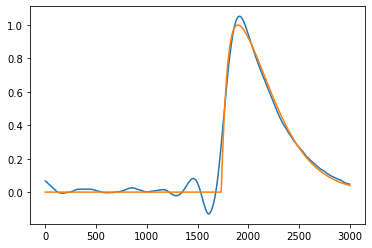

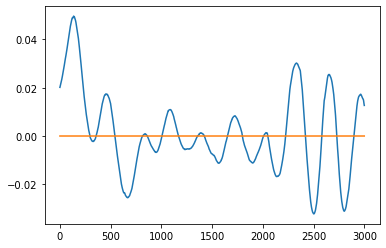

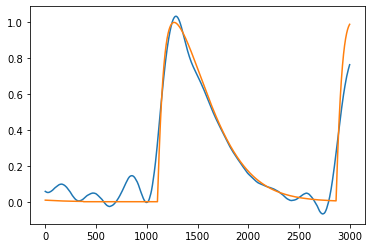

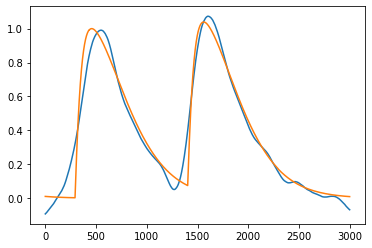

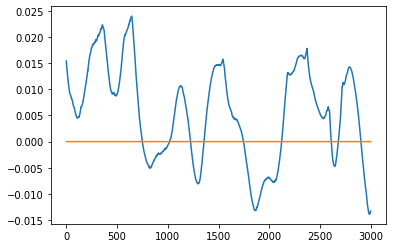

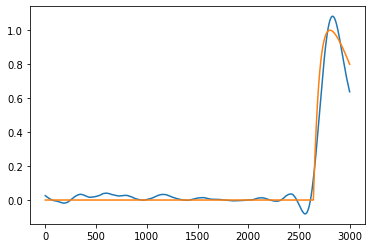

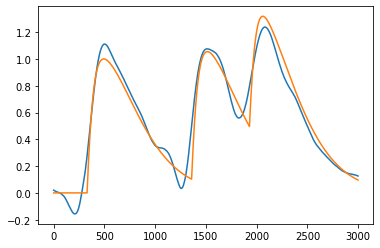

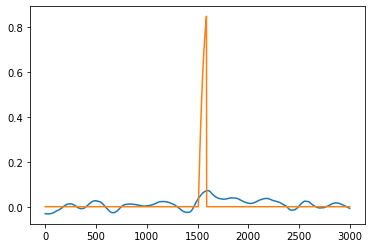

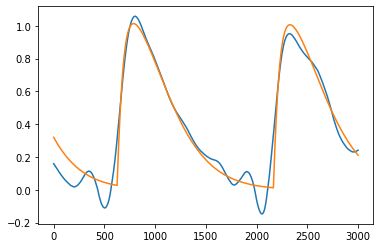

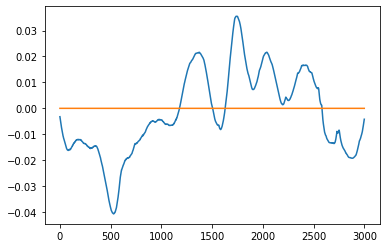

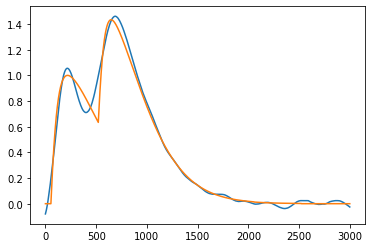

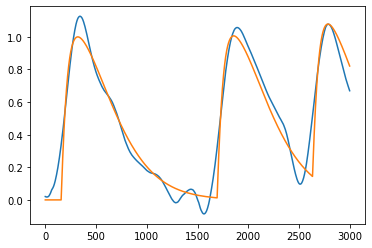

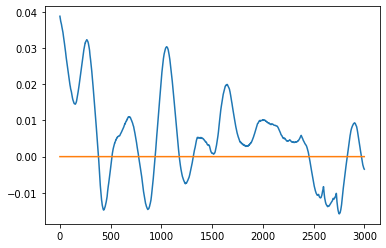

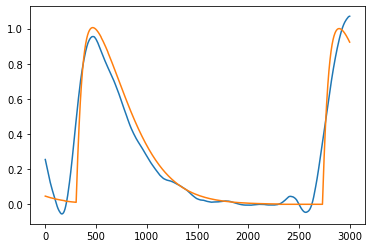

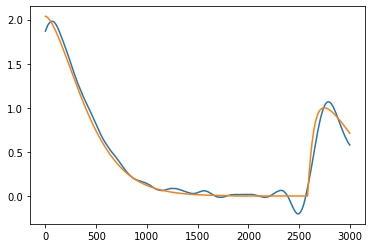

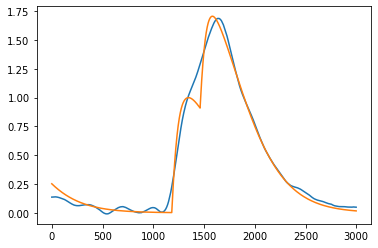

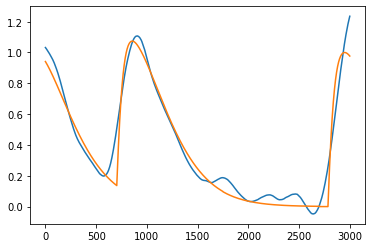

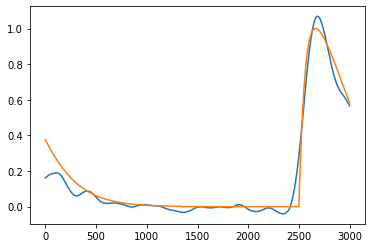

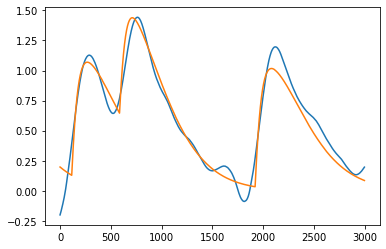

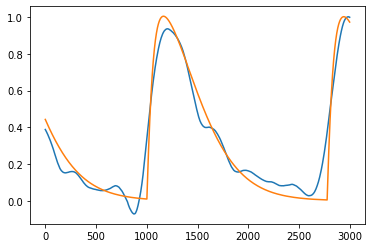

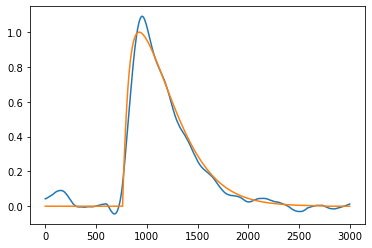

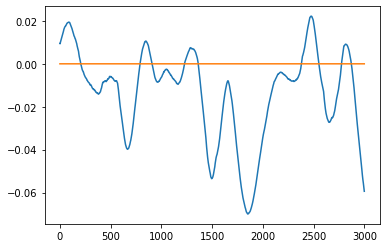

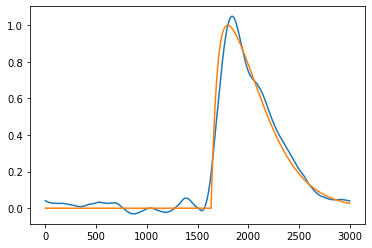

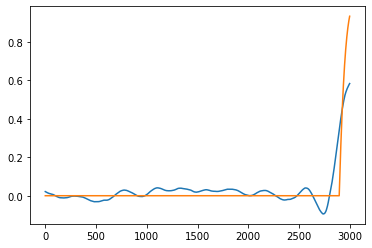

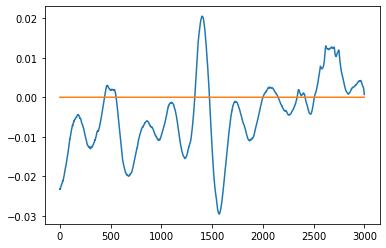

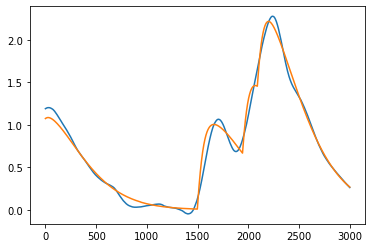

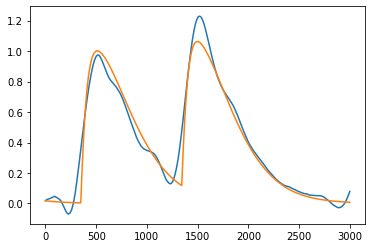

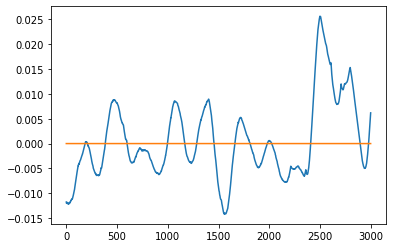

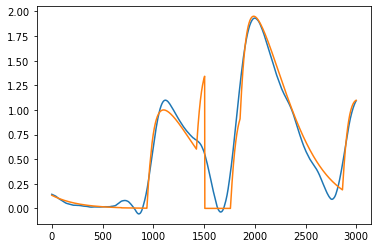

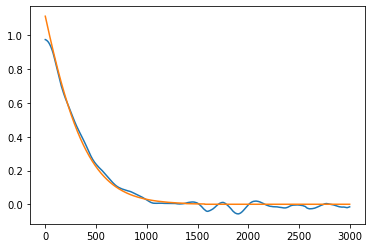

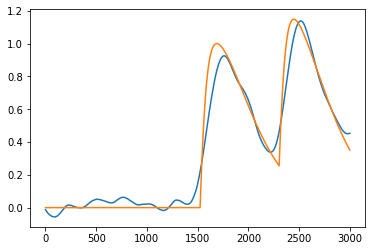

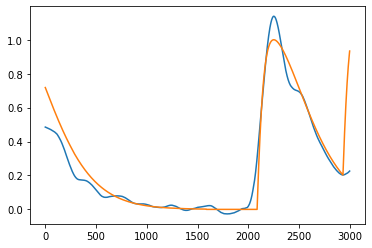

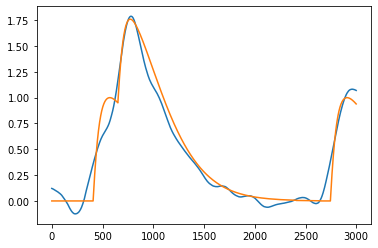

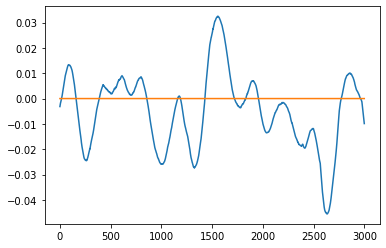

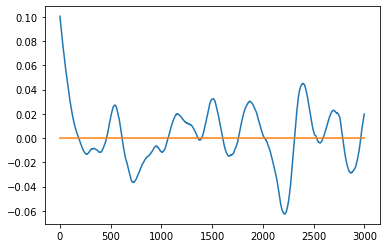

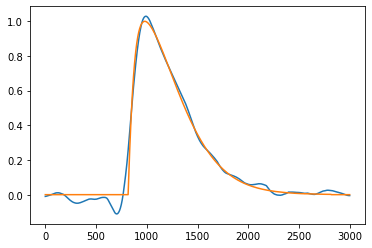

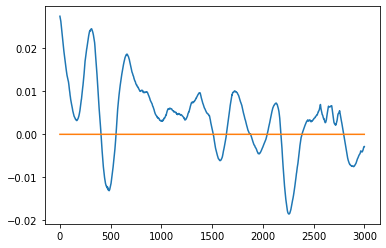

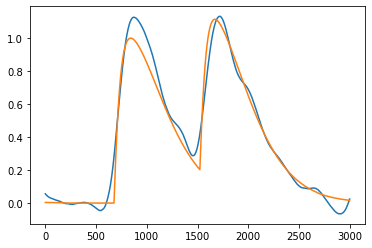

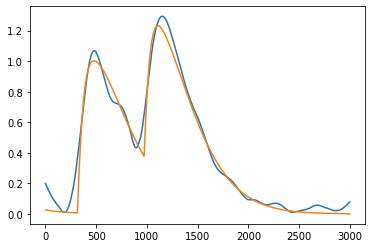

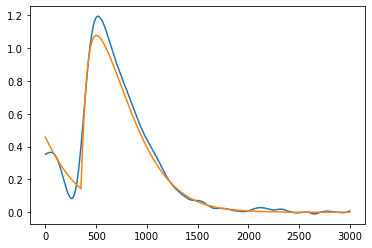

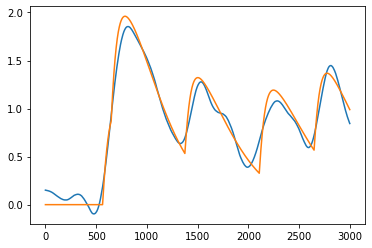

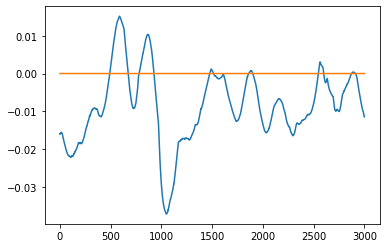

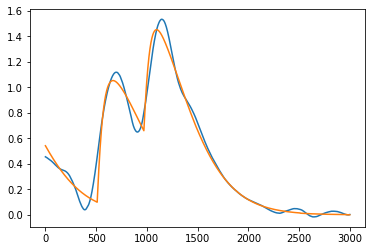

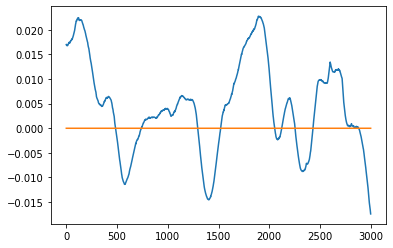

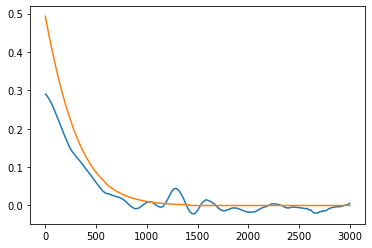

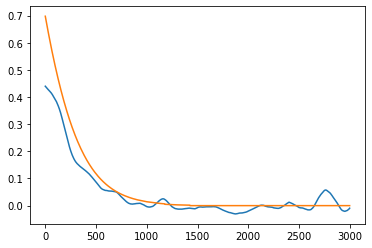

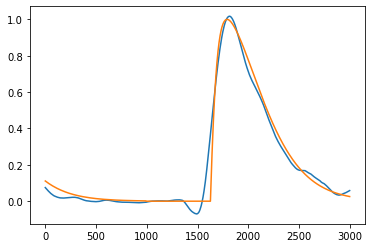

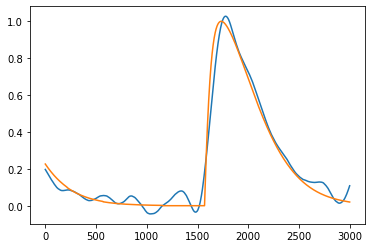

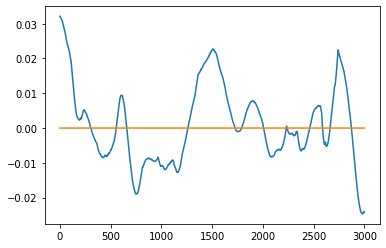

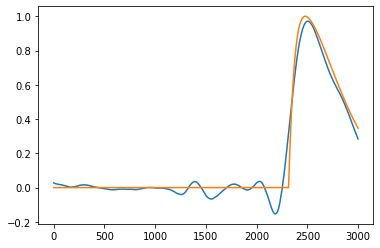

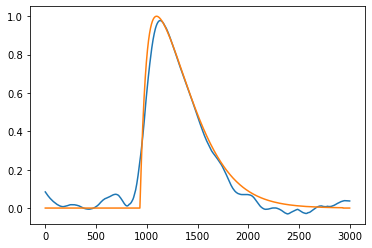

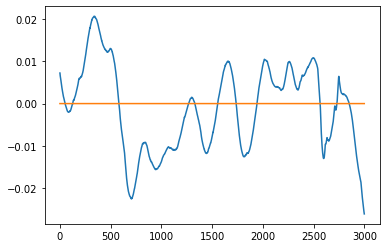

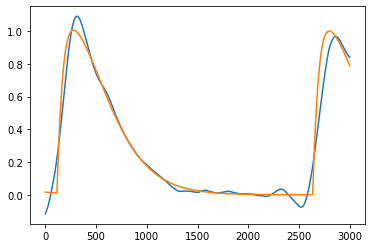

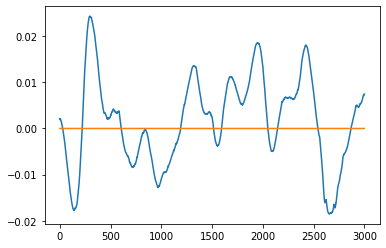

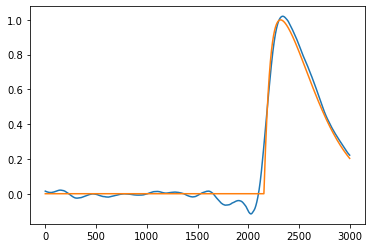

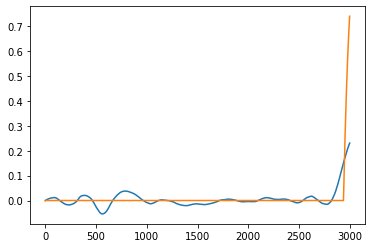

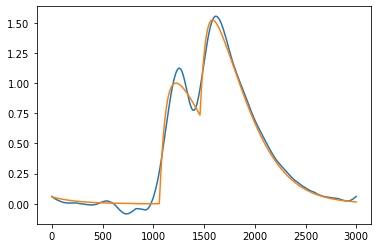

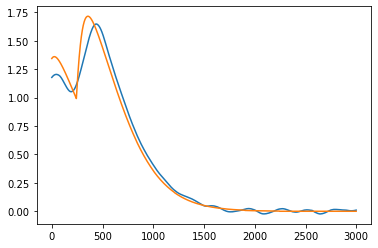

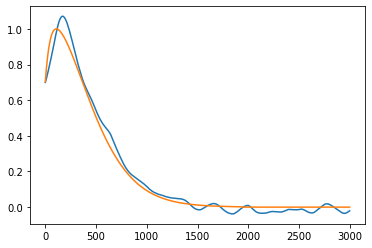

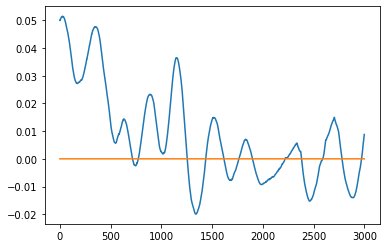

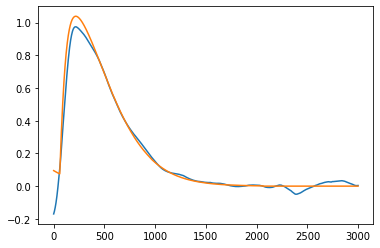

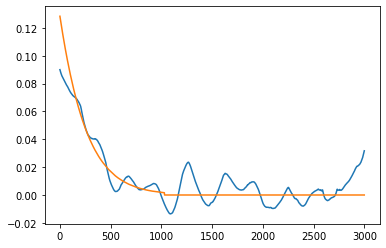

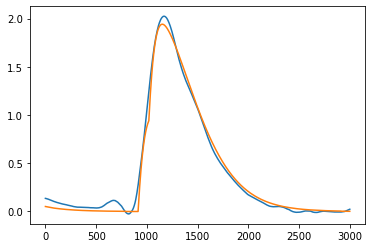

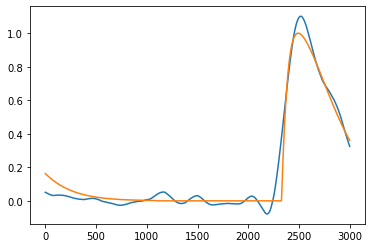

In [ ]:
vmi2 = np.asarray(vmi1)
for i in range(64):
    plt.plot(vmi2[i])
    plt.plot(y_t[i])
    plt.show()

In [ ]:
#evaluta explained variance
for i in range(50):
    mse = np.mean((vmi2[i]-y_t[i])**2)
    var = np.var(y_t[i])
    var_explained = 1-(mse/var)
    if(var>0.01):
        print(var_explained)

0.9828349907832548
0.9513602684548553
0.9548537335599795
0.9745506141673217
0.9517202901341634
0.9490875674628283
0.9848964130719572
0.945204076578472
0.9377152236896901
0.9843061636868575
0.9825148250493972
0.9531801259092789
0.970303172585523
0.944204958091426
0.9435242428026226
0.9782137226791823
0.9772201874852942
0.7555357300659995
0.9844261548709617
0.9601018495774765
0.9474164867191696
0.9917803779059604
0.9595879679245344
0.9078726516577628
0.9619548276667087
0.9871131223843179
0.967498788832217
0.9754544886542448
0.9784825289523233
0.9680179151174739
0.9795605172175675
0.8395039774430264
0.8853957498133993
0.9746900415246427
0.971018262166128
0.9748899639829982


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


In [ ]:
#get continous prediction
starting_point = 42500
x_eval = []
for i in range(17000):
    x_eval.append(np.reshape(x_vm[starting_point+i:starting_point+TIME_STEPS+i], [1,3000]))
x_eval = np.asarray(x_eval)

temp_pred = np.asarray(serve_CNN_LSTM(x_eval))

pred = [[] for i in range(temp_pred.shape[0])]
for i in range(temp_pred.shape[0]):
    for k in range(i):
        pred[i].append(0)
    for l in range(temp_pred.shape[1]):
        pred[i].append(temp_pred[i][l])
    for l in range((temp_pred.shape[0] + temp_pred.shape[1]) - len(pred[i])):
        pred[i].append(0)

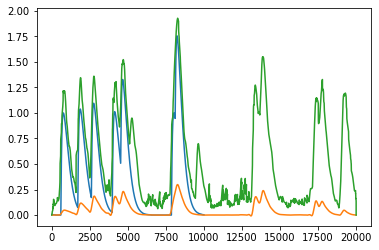

In [ ]:
meaned = np.mean(np.asarray(pred), axis=0)
maxed = np.max(np.asarray(pred), axis=0)
plt.plot(x_gcamp[starting_point:starting_point+10000])
plt.plot(meaned)
plt.plot(maxed)

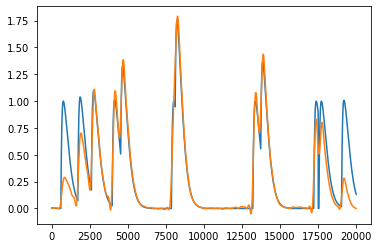

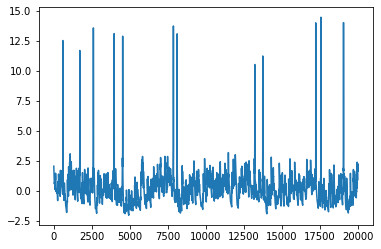

In [ ]:
plt.plot(x_gcamp[starting_point:starting_point+20000])
plt.plot(meaned*6)
plt.show()
plt.plot(x_vm[starting_point:starting_point+20000])

In [ ]:
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/Gcamp/prediction_pred.txt',meaned*6)
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/Gcamp/prediction_GT.txt',x_gcamp[starting_point:starting_point+20000])
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/Gcamp/prediction_vm.txt',x_vm[starting_point:starting_point+20000])


In [ ]:
y_t.shape

(64, 3000)

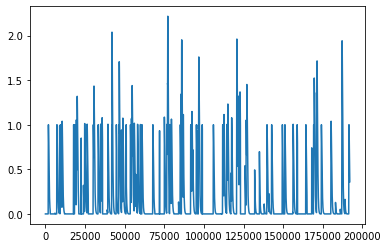

In [ ]:
"""
vmi2 = np.asarray(vmi1)
for i in range(64):
    plt.plot(vmi2[i])
    plt.plot(y_t[i])
    plt.show()
"""

plt.plot(y_t.flatten(order='C'))

In [ ]:
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/Gcamp/fit_pred.txt',vmi2.flatten(order='C'))
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/Gcamp/fit_GT.txt',y_t.flatten(order='C'))